In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

from evaluation import *

np.random.seed(5)

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
import scipy.io
mat = scipy.io.loadmat('/Users/OlgaKo/Desktop/one_plus_e/datasets/thyroid.mat')

X_data = mat["X"]
X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

In [4]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 5)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
X_good = X_train[np.where(y_train==0)[0]]

In [7]:
size = X_good.shape
noise = np.random.normal(0, 1e-4, size)*np.random.binomial(1, 0.2, size)

In [8]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [9]:
gm = GaussianMixture(n_components=7, n_init=6, verbose=2)

In [10]:
gm.fit(X_good+noise)

Initialization 0
  Iteration 0	 time lapse 0.03232s	 ll change inf
  Iteration 10	 time lapse 0.04892s	 ll change 0.02623
  Iteration 20	 time lapse 0.04456s	 ll change 0.00345
  Iteration 30	 time lapse 0.04642s	 ll change 0.00252
  Iteration 40	 time lapse 0.04602s	 ll change 0.00337
  Iteration 50	 time lapse 0.05031s	 ll change 0.00950
Initialization converged: True	 time lapse 0.30993s	 ll -1.48596
Initialization 1
  Iteration 0	 time lapse 0.01853s	 ll change inf
  Iteration 10	 time lapse 0.04574s	 ll change 0.02667
  Iteration 20	 time lapse 0.04336s	 ll change 0.00464
  Iteration 30	 time lapse 0.04943s	 ll change 0.00352
  Iteration 40	 time lapse 0.04732s	 ll change 0.00434
  Iteration 50	 time lapse 0.04584s	 ll change 0.00090
Initialization converged: True	 time lapse 0.25024s	 ll -1.49059
Initialization 2
  Iteration 0	 time lapse 0.02755s	 ll change inf
  Iteration 10	 time lapse 0.04553s	 ll change 0.01008
  Iteration 20	 time lapse 0.04751s	 ll change 0.00750
Initializ

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
from scipy.stats import multivariate_normal

In [12]:
n_samples = X_good.shape[0]

In [13]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [14]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [15]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [16]:
gen.shape

(1836, 6)

In [17]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-2)

In [18]:
#indices = gen_w.argsort()[-50:][::-1] #_toobig
#indices_toosmall = gen_w.argsort()[:200][::-1]

#indices = np.concatenate((indices_toosmall,indices_toobig))

In [19]:
#gen_w = np.delete(gen_w, indices)
#gen = np.delete(gen, indices, axis = 0)

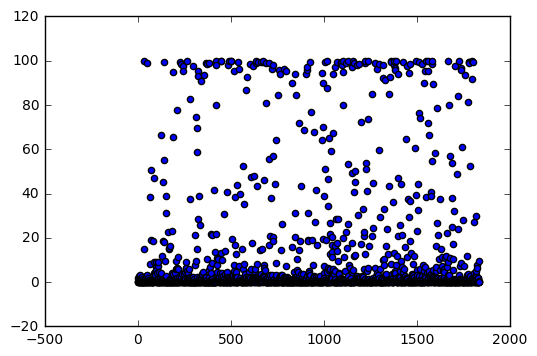

In [20]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [21]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [22]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [23]:
gen_w_normed.sum(), np.sum(weights)

(1839.9999999999995, 1840.0)

In [24]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [25]:
X_mix = np.vstack((X_good, gen)) #X_good

y_mix = np.vstack((y1, y2)) #y_train

weights_mix = np.vstack((weights.reshape(-1,1), gen_w_normed.reshape(-1,1))).reshape(-1)

In [26]:
weights_mix.shape

(3676,)

In [27]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [28]:
net = Sequential()
net.add(L.Dense(64, input_shape=(6,), activation = 'relu'))
#net.add(L.BatchNormalization())
#net.add(L.Dense(32, activation='relu'))
net.add(L.BatchNormalization())
net.add(L.Dropout(0.2))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [29]:
history = net.fit(X_mix, y_mix, batch_size=256, epochs=120, validation_split = 0.1, verbose=1, shuffle=True, sample_weight=weights_mix)

Train on 3308 samples, validate on 368 samples
Epoch 1/120
3308/3308 [==============================] - 0s - loss: 1.2251 - val_loss: 0.7954
Epoch 2/120
3308/3308 [==============================] - 0s - loss: 0.9398 - val_loss: 0.8291
Epoch 3/120
3308/3308 [==============================] - 0s - loss: 0.7513 - val_loss: 0.8380
Epoch 4/120
3308/3308 [==============================] - 0s - loss: 0.7138 - val_loss: 0.8333
Epoch 5/120
3308/3308 [==============================] - 0s - loss: 0.6231 - val_loss: 0.8543
Epoch 6/120
3308/3308 [==============================] - 0s - loss: 0.5892 - val_loss: 0.8782
Epoch 7/120
3308/3308 [==============================] - 0s - loss: 0.5736 - val_loss: 0.8913
Epoch 8/120
3308/3308 [==============================] - 0s - loss: 0.5485 - val_loss: 0.9153
Epoch 9/120
3308/3308 [==============================] - 0s - loss: 0.5397 - val_loss: 0.9400
Epoch 10/120
3308/3308 [==============================] - 0s - loss: 0.5391 - val_loss: 0.9597
Epoch 11/120

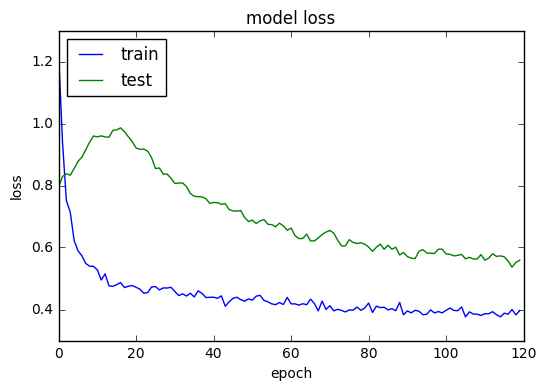

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
y_pred = net.predict(X_test, verbose=1)

1472/1886 [======================>.......] - ETA: 0s

f1_score  0.327526132404
confusion_matrix 
[[1646  193]
 [   0   47]]


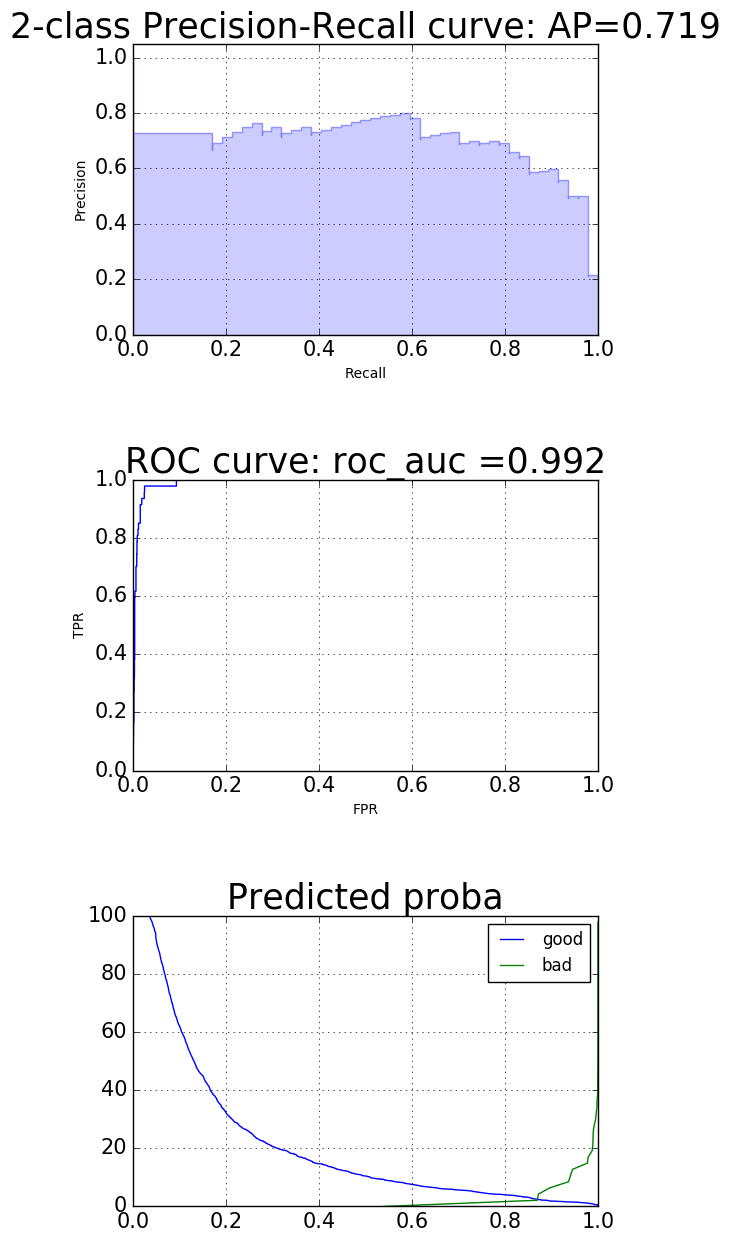

In [32]:
perfomance(y_test, y_pred)